In [1]:
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from deepcell_spots.dotnet import dot_net_2D
from tensorflow.keras.optimizers import SGD
from deepcell_spots import dotnet_losses

from deepcell_spots.postprocessing_utils import y_annotations_to_point_list_max
from deepcell_spots.point_metrics import stats_points, match_points_mutual_nearest_neighbor

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
model_dir = '../data/models/'

plm_weights_file = glob.glob(model_dir + '*plm*.h5')
log_weights_file = glob.glob(model_dir + '*log*.h5')
dog_weights_file = glob.glob(model_dir + '*dog*.h5')
sim_weights_file = glob.glob(model_dir + '*sim*.h5')
trackpy_weights_file = glob.glob(model_dir + '*trackpy*.h5')
em_weights_file = glob.glob(model_dir + '*em*.h5')
plm_weights_file

['/data/users/emily/models/conv_dots_model_plm.h5']

In [3]:
norm_method = None  # data normalization - options are: 'std','max', None, 'whole_image'
receptive_field = 13  # should be adjusted for the scale of the data
n_skips = 3  # number of skip-connections (only for FC training)
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [4]:
sigma=3.0
alpha=0.25
gamma=0.5
focal=False

dotnet_losses = dotnet_losses.DotNetLosses(sigma=sigma, alpha=alpha, gamma=gamma, focal=focal)

loss = {
    'offset_regression': dotnet_losses.regression_loss,
    'classification': dotnet_losses.classification_loss
}

loss_weights = {"offset_regression": 1.0, "classification": 1.0}

In [5]:
sim_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

sim_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
sim_model.load_weights(sim_weights_file[0])

2022-10-27 19:59:09.859109: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-27 19:59:09.886617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 19:59:10.556261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1


In [6]:
em_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

em_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
em_model.load_weights(em_weights_file[0])

In [7]:
plm_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

plm_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
plm_model.load_weights(plm_weights_file[0])

In [8]:
log_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

log_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
log_model.load_weights(log_weights_file[0])

In [9]:
dog_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

dog_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
dog_model.load_weights(dog_weights_file[0])

In [10]:
trackpy_model = dot_net_2D(receptive_field=receptive_field,
               input_shape=(128,128,1),
               inputs=None,
               n_skips=n_skips,
               norm_method=norm_method,
               padding_mode='reflect')

trackpy_model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer, metrics=['accuracy'])
trackpy_model.load_weights(trackpy_weights_file[0])

In [11]:
num_spots_list = np.linspace(20,300,6).astype(int)
stats_df = pd.DataFrame(columns=['Model', 'Image', 'Density', 'Precision', 'Recall', 'F1'])

data_dir = '../data/simulated_images/sim_images_density.npz'
sim_images_density = np.load(data_dir, allow_pickle=True)
X_density = sim_images_density['X']
y_density = sim_images_density['y']

for i in tqdm(range(np.shape(X_density)[0])):

    sim_pred_all = np.expand_dims(sim_model.predict(X_density[i]), axis=0)
    plm_pred_all = np.expand_dims(plm_model.predict(X_density[i]), axis=0)
    log_pred_all = np.expand_dims(log_model.predict(X_density[i]), axis=0)
    dog_pred_all = np.expand_dims(dog_model.predict(X_density[i]), axis=0)
    em_pred_all = np.expand_dims(em_model.predict(X_density[i]), axis=0)
    trackpy_pred_all = np.expand_dims(trackpy_model.predict(X_density[i]), axis=0)
    
    coords = y_density[i]

    pred_dict = {}
    pred_dict['Sim'] = sim_pred_all
    pred_dict['PLM'] = plm_pred_all
    pred_dict['LoG'] = log_pred_all
    pred_dict['DoG'] = dog_pred_all
    pred_dict['TrackPy'] = trackpy_pred_all
    pred_dict['Polaris'] = em_pred_all
    
    for key in pred_dict.keys():
        pred = {}
        pred['offset_regression'] = pred_dict[key][0][0]
        pred['classification'] = pred_dict[key][0][1]
        points_list = y_annotations_to_point_list_max(pred, threshold=0.98, min_distance=1)
        for ind in range(100):
            stats_dict = stats_points(coords[ind],
                                      points_list[ind],
                                      1,
                                      match_points_function=match_points_mutual_nearest_neighbor)
            temp_df = pd.DataFrame(columns=['Model', 'Image', 'Density', 'Precision', 'Recall', 'F1'])
            temp_df['Model'] = [key]
            temp_df['Image'] = [ind]
            temp_df['Density'] = [num_spots_list[i]]
            temp_df['Precision'] = [stats_dict['precision']]
            temp_df['Recall'] = [stats_dict['recall']]
            temp_df['F1'] = [stats_dict['F1']]

            stats_df = pd.concat([stats_df, temp_df])

  0%|                                                                                                                                  | 0/6 [00:00<?, ?it/s]2022-10-27 19:59:17.559727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return 

/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

In [12]:
summary_df = pd.DataFrame(columns=['Model'])

for model in stats_df.Model.unique():
    model_df = stats_df.loc[stats_df.Model == model]
    temp_df = pd.DataFrame(columns=['Model'])
    temp_df['Model'] = [model]
    for density in num_spots_list:
        slice_df = model_df.loc[model_df.Density == density]
        
        temp_df[str(density)] = np.mean(list(slice_df.F1))
    summary_df = pd.concat([summary_df, temp_df])
    
summary_df

,Model,20,76,132,188,244,300
0,Sim,0.850452,0.785393,0.706859,0.618859,0.530409,0.448641
0,PLM,0.567208,0.424208,0.339671,0.254328,0.188596,0.136044
0,LoG,0.915960,0.821265,0.721519,0.601750,0.500261,0.413655
0,DoG,0.918124,0.829595,0.740113,0.626309,0.528846,0.446871
0,TrackPy,0.918220,0.790940,0.653372,0.511296,0.397177,0.308849
0,Polaris,0.935783,0.850666,0.763798,0.657338,0.570878,0.497239


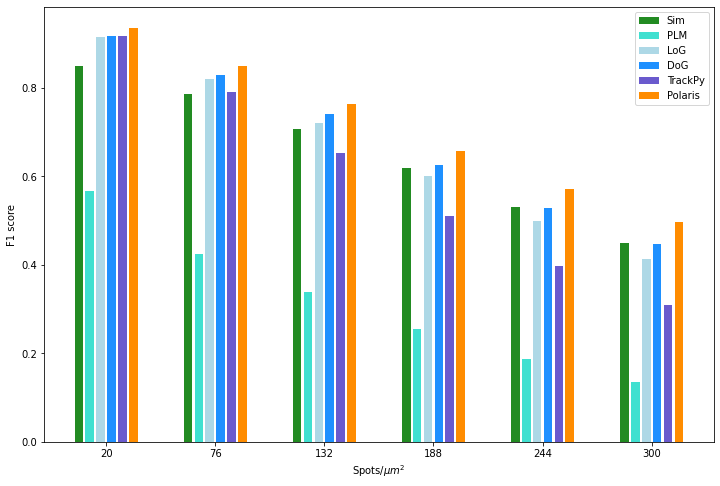

In [13]:
color_map = ['forestgreen','turquoise','lightblue','dodgerblue','slateblue','darkorange']

plt.figure(figsize=(12,8))
for i in range(len(summary_df)):
    plt.bar(np.arange(6)*10+i, summary_df.iloc[i][1:], width=0.8, label=summary_df.iloc[i][0], color=color_map[i])
plt.xticks(ticks=np.arange(6)*10+2.5, labels=list(summary_df.columns[1:]))
plt.xlabel('Spots/$\mu m^2$')
plt.ylabel('F1 score')
plt.legend()
plt.show()

In [ ]:
A_list = np.linspace(3,6,6)
stats_df_int = pd.DataFrame(columns=['Model', 'Image', 'Intensity', 'Precision', 'Recall', 'F1'])

data_dir = '../simulated_images/sim_images_intensity.npz'
sim_images_intensity = np.load(data_dir, allow_pickle=True)
X_intensity = sim_images_intensity['X']
y_intensity = sim_images_intensity['y']

for i in tqdm(range(np.shape(X_intensity)[0])):

    sim_pred_all = np.expand_dims(sim_model.predict(X_intensity[i]), axis=0)
    plm_pred_all = np.expand_dims(plm_model.predict(X_intensity[i]), axis=0)
    log_pred_all = np.expand_dims(log_model.predict(X_intensity[i]), axis=0)
    dog_pred_all = np.expand_dims(dog_model.predict(X_intensity[i]), axis=0)
    em_pred_all = np.expand_dims(em_model.predict(X_intensity[i]), axis=0)
    trackpy_pred_all = np.expand_dims(trackpy_model.predict(X_intensity[i]), axis=0)
    
    coords = y_intensity[i]

    pred_dict = {}
    pred_dict['Sim'] = sim_pred_all
    pred_dict['PLM'] = plm_pred_all
    pred_dict['LoG'] = log_pred_all
    pred_dict['DoG'] = dog_pred_all
    pred_dict['TrackPy'] = trackpy_pred_all
    pred_dict['Polaris'] = em_pred_all
    
    for key in pred_dict.keys():
        pred = {}
        pred['offset_regression'] = pred_dict[key][0][0]
        pred['classification'] = pred_dict[key][0][1]
        points_list = y_annotations_to_point_list_max(pred, threshold=0.98, min_distance=1)
        for ind in range(100):
            stats_dict = stats_points(coords[ind],
                                      points_list[ind],
                                      1,
                                      match_points_function=match_points_mutual_nearest_neighbor)
            temp_df = pd.DataFrame(columns=['Model', 'Image', 'Intensity', 'Precision', 'Recall', 'F1'])
            temp_df['Model'] = [key]
            temp_df['Image'] = [ind]
            temp_df['Intensity'] = [A_list[i]]
            temp_df['Precision'] = [stats_dict['precision']]
            temp_df['Recall'] = [stats_dict['recall']]
            temp_df['F1'] = [stats_dict['F1']]

            stats_df_int = pd.concat([stats_df_int, temp_df])

  0%|                                                                                                                                  | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: 

/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dot_centers)
/usr/local/lib/python3.8/dist-packages/deepcell_spots/postprocessing_utils.py:147: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

In [ ]:
summary_df_int = pd.DataFrame(columns=['Model'])

for model in stats_df_int.Model.unique():
    model_df = stats_df_int.loc[stats_df_int.Model == model]
    temp_df = pd.DataFrame(columns=['Model'])
    temp_df['Model'] = [model]
    for A in A_list:
        slice_df = model_df.loc[model_df.Intensity == A]
        
        temp_df[str(A)] = np.mean(list(slice_df.F1))
    summary_df_int = pd.concat([summary_df_int, temp_df])
    
summary_df_int

In [ ]:
plt.figure(figsize=(12,8))
for i in range(len(summary_df_int)):
    plt.bar(np.arange(6)*10+i, summary_df_int.iloc[i][1:], width=0.8, label=summary_df_int.iloc[i][0], color=color_map[i])
plt.xticks(ticks=np.arange(6)*10+2.5, labels=list(summary_df_int.columns[1:]))
plt.xlabel('Spot intensity')
plt.ylabel('F1 score')
plt.legend()
plt.show()